In [ ]:
#!pip install --target=$nb_path yfinance
#!pip install --target=$nb_path qiskit
!pip install qiskit_aqua
!pip install qiskit-aer

In [ ]:
import os, sys
from google.colab import drive
drive.mount('/content/drive')
nb_path = '/content/notebooks'
try:
  os.symlink('/content/drive/My Drive/quantum_ml/libs',nb_path)
except FileExistsError as f:
  pass
sys.path.insert(0,nb_path)
#os.unlink(nb_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import yfinance as yf
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from qiskit import *
import numpy as np
from qiskit.aqua.utils import split_dataset_to_data_and_labels, map_label_to_class_name
from qiskit.aqua import QuantumInstance
from qiskit.aqua.algorithms import VQC
from qiskit.aqua.algorithms import QSVM
from qiskit.circuit.library import ZZFeatureMap  


from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import time
from sklearn.metrics import accuracy_score
import random
import math
from  scipy.signal import find_peaks

In [ ]:
class Feature:
   def returns(self,data,period=1):
     
     d = np.log(data/ data.shift(period))
     return d
   def direction(self,df):
     d = df["Adj Close"]
     d = self.returns(d)
     d = np.where( d >= 0, +1,-1 )
     return d
   def change(self,data,period=1):
      d = data - data.shift(period)
      return d
    
   def SMA(self,data,period = 14):
      ma = data.rolling(period).mean()
      return ma   

   def MACD(self,data,a,b,c):
    """function to calculate MACD
       typical values a = 12; b =26, c =9"""
    ma_fast = data.ewm(span=a,min_periods=a).mean()
    ma_slow = data.ewm(span=b,min_periods=b).mean()
    macd = ma_fast-ma_slow
    signal = macd.ewm(span=c,min_periods=c).mean()
    return signal
  
   def EF(self,df,window=10):
    '''ehler fishher transform'''
    a = list(df.columns).index("Adj Close")
    b = list(df.columns).index("Low")
    c = list(df.columns).index("High")
    xa = np.zeros((len(df),1),dtype=np.float32)
    end = len(df)
    for i in range(end):      
      xa[i] = (df.iloc[i,a] - df.iloc[i-window:i,b].min() ) / (df.iloc[i-window:i,c].max()-df.iloc[i-window:i,b].min() + 10**-15)

    xb = 2*xa - 1
    for i in range(len(xb)):
      if xb[i] == 1:
        xb[i] = 0.999
      elif xb[i] == -1:
        xb[i] = -0.999
    xc = 0.5*np.log(abs(1+xb)/abs(1-xb)) 
    return xc 
     
   def Awesome(self,df,sa = 5, sb = 34):
     xa = df["Adj Close"].rolling(sa).mean()
     xb = df["Adj Close"].rolling(sb).mean()
     xc = xa - xb
     return xc

   def custom_signal_1(self,data,column=None):
    " peaks and troughs of SMA "
    res,_ = find_peaks(self.data[column])
    res2,_ = find_peaks(-self.data[column])
    indexes = np.sort(np.concatenate((res,res2),axis=-1))
    peaks = data.iloc[indexes]['Adj Close']
    dates = data.iloc[indexes].index
    
 
    signal = []
    for i in range(len(data)-1):
        break

    for i in range(len(peaks)-3):
      a,b,c,d = peaks[i],peaks[i+1],peaks[i+2],peaks[i+3]
      if (b - a > 0)|(c-a >0):
        if (c-a > 0 )|(d -a > 0 ):
          if (d-a > 0 ):
            self.data.loc[dates[i],['signals']]=3
          
            continue
        
          self.data.loc[dates[i],['signals']]=2
          continue
      
        self.data.loc[dates[i],['signals']]=1
      else:
        
        
        self.data.loc[dates[i],['signals']]=-1
    self.data['signals']=0
    return 


In [ ]:
class StockData():
  def __init__(self,ticker,min_max=False,step_size=10,categorical=True):
    
    self.data = None
    self.min_max = min_max
    self.min_max_y =None
    self.min_max_data = None
    self.X_label = ["Open","High","Low","Adj Close"]
   #["EFO","EFH","EHL","EHC"]
    self.Y_label = ["Direction"]
    self.ticker = ticker
    self.step_size= step_size
    self.prediction_period = 1
    self.feature_obj = Feature()
    self.download(ticker)
    self.features()
    self.data.dropna(inplace=True)
    #self.dataframe_out()
    print(self.data.columns)
    self._pre_minmax()
    self.new_dataset(step_size = self.step_size, pred_period = self.prediction_period)
    self.categorical = categorical
    return 
  
  def dataframe_out(self, columns=None):
    if not columns:
        columns = self.X_label + self.Y_label
    self.data = self.data[columns]
    return self.data

  def features(self,period=1):
    self.data['EFO'] = self.feature_obj.EF(self.data)
    #self.data["Day"] = self.data.index.dayofweek
    #self.data['SMA14'] = self.feature_obj.SMA(self.data['Adj Close'],period=14)
    #self.data['Returns'] = self.feature_obj.returns(self.data['Adj Close'])
    #self.data['EF'] = self.feature_obj.EF(self.data)
    #self.data['Awesome'] = self.feature_obj.Awesome(self.data)
    self.data['Direction'] = self.feature_obj.direction(self.data)
    return
  
  @staticmethod
  def train_test_val_split(X,Y,split = 0.1, val = True,shuffle=True):
    x1,x2,y1,y2 = train_test_split(X, Y, test_size=0.1, shuffle=False)
    if val:
      x1,x3,y1,y3 = train_test_split(x1, y1, test_size=0.1, shuffle=shuffle)
      return x1,x3,x2,y1,y3,y2
    else:
      return x1,x2,y1,y2

  def download(self,ticker,Id=".NS"):
    if self.data == None:
      if type(ticker) == str:
        ticker = ticker + Id
        self.data = yf.download(ticker)
 

  def new_dataset(self, step_size=30, pred_period=1):
    if self.min_max ==True:
      X = self.min_max_x.transform(self.data.iloc[:][self.X_label])
      Y = self.min_max_y.transform(self.data.iloc[:][self.Y_label])
    else:
      X = self.data.iloc[:][self.X_label]
      Y = self.data.iloc[:][self.Y_label]
    data_X,data_Y = [], []
    for i in range(self.data.shape[0]-step_size-pred_period-1):
# here is the inclusion of features for the model
        a =X[i:(i+step_size)]
        data_X.append(a)
        b = Y[i+step_size:i+step_size+pred_period]
        data_Y.append(b)
    self.X,self.Y=  np.array(data_X), np.array(data_Y)
    return
  
  def _pre_minmax(self):
    self.min_max_x = MinMaxScaler()
    self.min_max_y = MinMaxScaler()
    self.min_max_x.fit(self.data[self.X_label])
    self.min_max_y.fit(self.data[self.Y_label])
    return 









In [ ]:
obj = StockData("TRIVENI",min_max=True)

[*********************100%***********************]  1 of 1 completed
Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'EFO',
       'Direction'],
      dtype='object')


In [ ]:
df = obj.data

In [ ]:
df.head(200)

,Open,High,Low,Close,Adj Close,Volume,Day,SMA14,Returns,EF,Awesome,Direction
Date,,,,,,,,,,,,
2006-01-31,46.374359,46.731720,44.615047,44.999897,38.960705,2958425,1,40.463514,-0.028900,-0.476183,3.079031,-1
2006-02-01,45.577171,46.979122,43.213097,43.817860,37.937305,3263441,2,40.313914,-0.026619,-0.410675,2.271367,-1
2006-02-02,44.422623,44.972408,42.141014,43.295563,37.485100,2937361,3,40.099713,-0.011991,-0.469008,1.037262,-1
2006-02-03,43.103142,45.082367,43.020672,43.542969,37.699310,4557503,4,39.977313,0.005698,-0.588800,-0.056700,1
2006-02-06,44.037773,44.725006,43.295563,43.597946,37.746906,1902738,0,39.936513,0.001262,-0.592533,-0.740042,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2006-11-14,35.433640,35.433640,34.636452,34.718918,30.688765,404298,1,32.296873,-0.011024,-0.289043,-1.726396,-1
2006-11-15,34.911343,34.911343,33.481903,33.839264,29.911224,782174,2,32.021115,-0.025663,-0.281599,-2.058127,-1
2006-11-16,33.866753,34.086666,33.591862,33.976711,30.032719,585687,3,31.754034,0.004054,-0.431614,-2.408203,1


In [ ]:
train_data = df[["Open","High","Low","Adj Close"]].to_numpy()
labels = df['Direction'].shift(-1).to_numpy()
print(train_data.shape,labels.shape)

(3988, 4) (3988,)


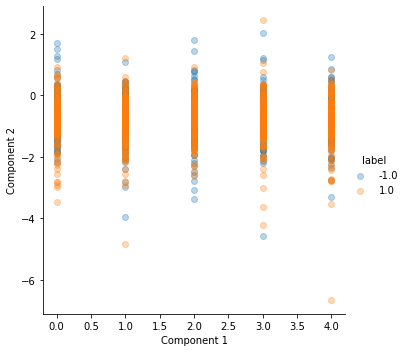

In [ ]:
def plotdataset(X,Y,c1,c2,N):
  cmp1 = f"Component {c1}"
  cmp2 = f"Component {c2}"
  dataset = pd.DataFrame({cmp1:X[:N,c1], cmp2:X[:N,c2], 'label':Y[:N]})
  sns.lmplot(data=dataset, x =cmp1, y=cmp2, fit_reg=False, hue='label',scatter_kws={'alpha':0.3})
  return

plotdataset(train_data,labels,1,2,N=2000)

In [ ]:
np.random.seed(0)
tsne = TSNE(n_components = 2)
train_data_tse = tsne.fit_transform(train_data[:,[2,3]])

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


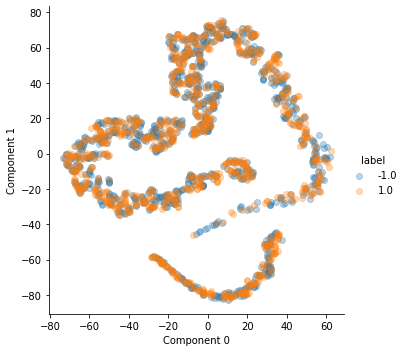

In [ ]:
plotdataset(train_data_tse,labels,0,1,N=2000)

train_data = train_data_tse


In [ ]:
train_data.shape

(3988, 4)

In [ ]:
buy_data_array = []
sell_data_array = []
for i in range(3000):
  if labels[i] == 1:
    buy_data_array.append(train_data[i,:])
for i in range(3000):
  if labels[i] == -1:
    sell_data_array.append(train_data[i,:])  
buy = np.array(buy_data_array)
sell = np.array(sell_data_array)

def normalize(arr,max_val,n):
  a = np.divide(arr,max_val)
  return a +n
#norm_buy = normalize(buy,100,1)
#norm_sell = normalize(sell,100,1)
norm_buy = buy
norm_sell = sell

In [ ]:
train_size = 500
test_size = 20
dp_size = 5


buy_train = norm_buy[:train_size]
sell_train = norm_sell[:train_size]

buy_test = norm_buy[train_size+1:train_size+test_size+1] 
sell_test = norm_sell[train_size+1:train_size+test_size+1]

training_input = {'A':buy_train,'B':sell_train }
test_input = {'A': buy_test, 'B':sell_test}

val_data = []
v_dp_buy = norm_buy[train_size+test_size+2:train_size+test_size+2+dp_size]
v_dp_sell = norm_sell[train_size+test_size+2:train_size+test_size+2+dp_size]

datapoints = []
datapoints.append(np.concatenate((v_dp_buy,v_dp_sell)))
v_dp_y = np.array([1,1,1,1,1,0,0,0,0,0])
datapoints.append(v_dp_y)

class_to_label = {'A':1,'B':0}


In [ ]:
feature_dim = train_data.shape[1]
seed = 100
print(feature_dim)



4


In [ ]:

backend = BasicAer.get_backend('qasm_simulator')
backend_options = {'method':'statevector'}
quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator = seed, seed_transpiler =seed, backend_options=backend_options )

In [ ]:
feature_map = ZZFeatureMap(feature_dimension=feature_dim, reps=3, entanglement='full')

In [ ]:
from qiskit.circuit.library  import EfficientSU2
var_circuit = EfficientSU2(feature_dim, reps = 5)

In [ ]:
from qiskit.aqua.components.optimizers import COBYLA
cobyla = COBYLA(maxiter = 500, tol= 0.001)

In [ ]:
vqc = VQC( optimizer = cobyla, feature_map = feature_map , var_form = var_circuit,
          training_dataset = training_input, test_dataset = test_input, datapoints= datapoints[0])




In [ ]:
result = vqc.run(quantum_instance)

print("testing accuracy: {}".format(result['testing_accuracy']))
print("prediction of datapoints:")
print("Actual: {}".format(map_label_to_class_name(datapoints[1], vqc.label_to_class)))
print("prediction:   {}".format(result['predicted_classes']))

testing accuracy: 0.325
prediction of datapoints:
Actual: ['B', 'B', 'B', 'B', 'B', 'A', 'A', 'A', 'A', 'A']
prediction:   ['A', 'A', 'A', 'A', 'B', 'A', 'B', 'A', 'B', 'A']


In [ ]:
feature_map = ZZFeatureMap(feature_dimension=feature_dim, reps=2, entanglement='linear')
qsvm = QSVM(feature_map, training_input, test_input, datapoints[0])

backend = Aer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=seed, seed_transpiler=seed)

result = qsvm.run(quantum_instance)

print(f"Testing Accuracy: {result['testing_accuracy'] * 100}%")
print("Prediction on Datapoints:")
print(f"Ground Truth: {map_label_to_class_name(datapoints[1], qsvm.label_to_class)}")
print(f"Predictions:  {result['predicted_classes']}")

ValueError: ignored

In [ ]:
print("Trained Kernel Matrix:")
kernel_matrix = result['kernel_matrix_training']
img = plt.imshow(np.asmatrix(kernel_matrix),interpolation='nearest',origin='upper',cmap='bone_r')
plt.show()